<a href="https://colab.research.google.com/github/liao771018/Team-Project/blob/main/tSNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install --upgrade tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 36.1 MB/s 


In [ ]:
from tensorflow.keras import applications
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
# from tensorflow_addons.optimizers import RectifiedAdam, Lookahead
import numpy as np
from glob import glob
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import manifold


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 準備資料

In [ ]:
# 模型要用的圖片大小
IMG_SIZE = 224

# 讀取資料
img_dir = '/content/drive/MyDrive/12_團體專題_第四組/01_圖片資料/02_進模型的圖片'

trains = glob(img_dir + '/train/*')
tests = glob(img_dir + '/test/*')

print('train:', len(trains))
print('test:', len(tests))

train: 6088
test: 838


In [ ]:
# 把題目跟答案做成 DataFrame
train_df = pd.DataFrame({
              'img_path': trains,                  
})
test_df = pd.DataFrame({
              'img_path': tests
})


def ans(img_path):
  # 取出藏在檔名的答案
  label = img_path.split('/')[-1].split('_')[0]
  return label


train_df['label'] = train_df['img_path'].apply(ans)
test_df['label'] = test_df['img_path'].apply(ans)

test_df

,img_path,label
0,/content/drive/MyDrive/12_團體專題_第四組/01_圖片資料/02_...,octopus
1,/content/drive/MyDrive/12_團體專題_第四組/01_圖片資料/02_...,octopus
2,/content/drive/MyDrive/12_團體專題_第四組/01_圖片資料/02_...,octopus
3,/content/drive/MyDrive/12_團體專題_第四組/01_圖片資料/02_...,octopus
4,/content/drive/MyDrive/12_團體專題_第四組/01_圖片資料/02_...,octopus
...,...,...
833,/content/drive/MyDrive/12_團體專題_第四組/01_圖片資料/02_...,neritic squid
834,/content/drive/MyDrive/12_團體專題_第四組/01_圖片資料/02_...,neritic squid
835,/content/drive/MyDrive/12_團體專題_第四組/01_圖片資料/02_...,neritic squid
836,/content/drive/MyDrive/12_團體專題_第四組/01_圖片資料/02_...,neritic squid


In [ ]:
# 轉換答案的字典
cls2idx = {
        'bigfin squid': 0,        
        'neritic squid': 1,
        'octopus': 2,
        'squid': 3,
        'cuttlefish': 4,
}

idx2cls = { v: k for k, v in cls2idx.items()}


cls2idx, idx2cls

({'bigfin squid': 0,
  'cuttlefish': 4,
  'neritic squid': 1,
  'octopus': 2,
  'squid': 3},
 {0: 'bigfin squid',
  1: 'neritic squid',
  2: 'octopus',
  3: 'squid',
  4: 'cuttlefish'})

In [ ]:
x_train_path = np.array(train_df['img_path'])
y_train = np.array(train_df['label'].replace(cls2idx))


x_test_path = np.array(test_df['img_path'])
y_test = np.array(test_df['label'].replace(cls2idx))

# 看一下 shape 是否一樣
x_test_path.shape, y_test.shape, x_train_path.shape, y_train.shape

((838,), (838,), (6088,), (6088,))

In [ ]:
# 建立批次讀圖後送進模型的函式

def get_data(x, y, i=None, batch=None):
    # x : 圖片路徑
    # y : 答案

    # 如果不是 None, 那代表是數字，取出這個數量的 idx
    # 範例 batch=20, 隨機 20 個idx
    # 如果是 None, 那就沒有隨機取, 取全部 idx
    if batch is not None:

      idx = np.random.randint(0, len(x), size=batch) # 在(0, len(x))取隨機的 size 個數 (可能取到重覆的)
      x, y = x[idx], y[idx]
      # 這時候 x, y 會是一批隨機的資料

    
    # img_pre: preprocess後的圖
    # img_ori: 原圖
    img_pre, img_ori = [], []

    for p in x:

      img = cv2.imread(p)[:,:,::-1]
      img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
      img = np.array(img)
      img_pre.append(applications.efficientnet.preprocess_input(img))
      img_ori.append(img)

    return (np.array(img_pre), np.array(img_ori), y)

In [ ]:
x_train, x_train_ori, y_train_ = get_data(x_train_path, y_train)
x_test, x_test_ori, y_test = get_data(x_test_path, y_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6088, 224, 224, 3), (6088,), (838, 224, 224, 3), (838,))

# 讀取模型

In [ ]:
model_path = '/content/drive/MyDrive/12_團體專題_第四組/02_模型/09_EfficientNetB4/EfficientNetB4_TP_7_Ranger_best.h5'

model = load_model(model_path, compile=False)
model2 = Model(model.inputs, 
         model.layers[-2].output)

model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

In [ ]:
model.evaluate(x_test, y_test)
# [0.06979230046272278, 0.9725536704063416]

RuntimeError: ignored

# Test tSNE

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 838 samples in 0.001s...
[t-SNE] Computed neighbors for 838 samples in 0.030s...
[t-SNE] Computed conditional probabilities for sample 838 / 838
[t-SNE] Mean sigma: 2.265127
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.106781
[t-SNE] KL divergence after 1000 iterations: 0.603581


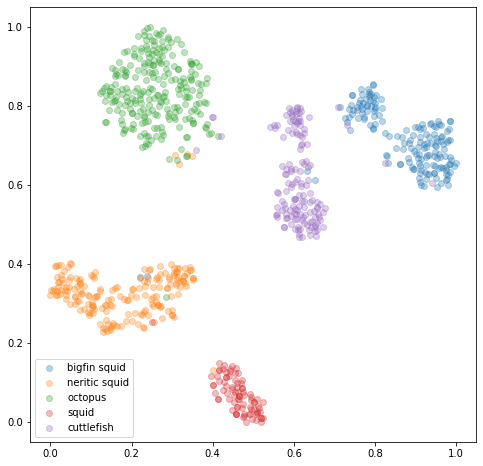

"\n  {0: 'bigfin squid',\n  1: 'neritic squid',\n  2: 'octopus',\n  3: 'squid',\n  4: 'cuttlefish'}\n"

In [ ]:
x_test_features = model2.predict(x_test)

x_tsne = manifold.TSNE(n_components=2, 
            init='random', 
            random_state=5566, 
            verbose=1).fit_transform(x_test_features)

# normalize
x_min, x_max = x_tsne.min(0), x_tsne.max(0)
x_norm = (x_tsne - x_min) / (x_max - x_min)

# print(x_min, x_max, x_tsne)
# print(x_norm)

plt.figure(figsize=(8, 8))
cmap = plt.cm.get_cmap("tab20", 10)

for digit in range(len(cls2idx)):
    # idx = y_train_raw[:N_SAMPLES] == digit
    idx = y_test == digit
    plt.scatter(x_norm[idx, 0], 
          x_norm[idx, 1], 
          color=cmap(digit), 
          label=idx2cls[digit], 
          alpha=0.3,
          )

plt.legend()
plt.show()

'''
  {0: 'bigfin squid',
  1: 'neritic squid',
  2: 'octopus',
  3: 'squid',
  4: 'cuttlefish'}
'''

# Train tSNE

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6088 samples in 0.001s...
[t-SNE] Computed neighbors for 6088 samples in 1.201s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6088
[t-SNE] Computed conditional probabilities for sample 2000 / 6088
[t-SNE] Computed conditional probabilities for sample 3000 / 6088
[t-SNE] Computed conditional probabilities for sample 4000 / 6088
[t-SNE] Computed conditional probabilities for sample 5000 / 6088
[t-SNE] Computed conditional probabilities for sample 6000 / 6088
[t-SNE] Computed conditional probabilities for sample 6088 / 6088
[t-SNE] Mean sigma: 1.525489
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.975601
[t-SNE] KL divergence after 1000 iterations: 1.222561


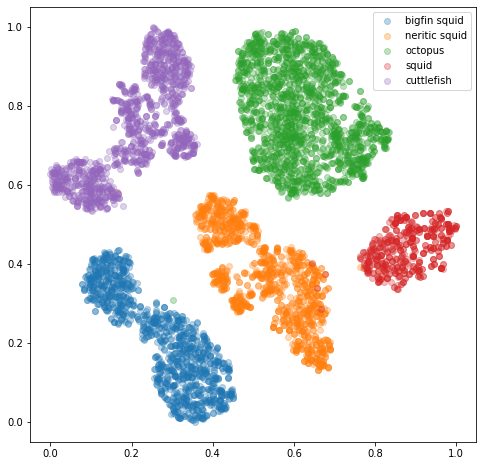

In [ ]:
x_train_features = model2.predict(x_train)

x_tsne = manifold.TSNE(n_components=2, 
            init='random', 
            random_state=5566, 
            verbose=1).fit_transform(x_train_features)

x_min, x_max = x_tsne.min(0), x_tsne.max(0)
x_norm = (x_tsne - x_min) / (x_max - x_min)

plt.figure(figsize=(8, 8))
cmap = plt.cm.get_cmap("tab20", 10)

for digit in range(len(cls2idx)):

    idx = y_train_ == digit
    plt.scatter(x_norm[idx, 0], 
          x_norm[idx, 1], 
          color=cmap(digit), 
          label=idx2cls[digit], 
          alpha=0.3,
          )

plt.legend()
plt.show()

In [ ]:
img = cv2.imread("1.jpg")
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img = np.array(img).reshape(1, IMG_SIZE, IMG_SIZE, 3)
img = applications.efficientnet.preprocess_input(img)

result = model.predict(img)
idx2cls[result[0].argmax(axis=-1)]

'bigfin squid'